In [1]:
from pylsl import StreamInlet, resolve_stream
import numpy as np
import pandas as pd

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, KFold
import matplotlib.pyplot as plt

from scipy import stats
from scipy.stats import zscore

import time

import seaborn as sns

#### functions for feature calculations

In [2]:
def rms(values):
    return np.sqrt(np.sum(np.square(values))/len(values))

def mav(values):
    return np.sum(np.absolute(values))/len(values)    

def var(values):
    return np.sum(np.square(values))/(len(values)-1)

def wl_exp(values):
    wavelen = np.sum(np.abs(values[:-1]-values[1:]))
    return wavelen

def wl(values):
    val_array = values.to_numpy()
    wavelen = np.sum(np.abs(val_array[:-1]-val_array[1:]))
    return wavelen

def zc(values):
    val_array = values.to_numpy()
    zero_crossings = np.where(np.diff(np.signbit(val_array)))[0]
    return len(zero_crossings)

def zc_exp(values):
    val_array = values.to_numpy()
    zero_crossings = np.where(np.diff(np.signbit(val_array)))[0]
    return len(zero_crossings)

### TRAINING

In [3]:
def read_from_file(file: str):
    data = pd.read_csv(file)
    return data.loc[data["direction"] > 0]

path_lg = '/Users/lukasgehrke/Documents/publications/proxEMG/data/4_chan/'
path_nw = 'C:/Users/Nils/Documents/02_Uni/Master Human Factors/\
00_Masterarbeit/55_github/proxEMG/data/user_study/'
path_mac_old = '/Users/work/Desktop/Nils/study/4_chan/'
path_mac = '/Users/work/Desktop/Nils/proxEMG/data/user_study/'

device = path_nw

In [4]:
def feature_calculation(data:pd.DataFrame, win_size=None, baseline=False, baseline_size=1):
    df = pd.DataFrame()
    n_epoch = data['epoch_ixs'].max()
    
    for i in range(1,n_epoch+1):
        
        data_curr = data[data['epoch_ixs']==i]

        if win_size is not None: # get middle window
            middle_t = (len(data_curr)-1) / 2
            start_t = int(np.floor(middle_t - win_size/2))
            end_t = int(np.floor(middle_t + win_size/2))
            data_curr = data_curr[start_t:end_t]

        if baseline:
            base = data_curr.iloc[0:baseline_size,2:].mean()
            data_curr.iloc[:,2:] = data_curr.iloc[:,2:] - base
        
        # df_curr = data_curr[:win_size].filter(muscles_list[:-1]).agg(features_selected).melt().transpose()[-1:]
        df_curr = data_curr.filter(muscles_list).agg(features_selected).melt().transpose()[-1:]
        df_curr['direction'] = data_curr.direction.values[0]
        
        df = pd.concat([df,df_curr], axis=0, ignore_index=True)
        #print(i)
    
    return df

In [5]:
%%time

features_selected = [wl, mav, var]
muscles_list = ["muscle1","muscle2", "muscle3","muscle4"]

windowsize = 250
baselinesize = windowsize

import warnings
warnings.filterwarnings('ignore')

n_participants = 6

dict_rot = {}
dict_ges = {}


for i in range (1,n_participants+1):
    subject_id = str(0)+str(i)
    path_rot = device + subject_id + '/' + subject_id + '_training_rotation.csv'
    path_ges = device + subject_id + '/' + subject_id + '_training_gesture.csv'
    
    all_data_rot = feature_calculation(read_from_file(file=path_rot), win_size=windowsize, baseline=True, baseline_size=baselinesize)
    all_data_ges = feature_calculation(read_from_file(file=path_ges), win_size=windowsize, baseline=True, baseline_size=baselinesize)
    
    # zusammenfassen von no_rot_left & no_rot_right
    all_data_rot['direction'] = all_data_rot['direction'].replace([4],[3])

    # check class sizes
    freq_rot = all_data_rot['direction'].value_counts() 
    freq_ges = all_data_ges['direction'].value_counts()

    # sample all classes to smallest class size
    sample_data_ges = all_data_ges.groupby('direction').sample(n=min(freq_ges), random_state=42)
    sample_data_rot = all_data_rot.groupby('direction').sample(n=min(freq_rot), random_state=42)
    
    dict_rot[i] = sample_data_rot
    dict_ges[i] = sample_data_ges
    
# access data via
# dict_rot[i]

Wall time: 40.1 s


In [6]:
dict_rot[1]

,0,1,2,3,4,5,6,7,8,9,10,11,direction
13,2582.0,23.092781,806.056305,9135.2,53.907232,5300.306666,3904.7,44.52537,3049.058364,7554.7,44.41385,3575.726362,1
39,1842.3,13.740602,271.224769,2851.2,23.438976,868.204273,4992.4,29.09233,2134.965495,3400.0,46.952531,3066.344501,1
30,2255.0,24.876301,813.808004,4309.0,25.195395,1093.319966,3110.9,31.833898,1521.647809,7858.9,41.740787,3048.109442,1
45,1367.7,44.20168,2539.793835,2444.0,16.818851,469.608604,6104.2,62.41,6227.420325,4003.7,21.590464,822.169865,1
17,2274.1,34.137498,1699.142648,7764.3,43.932576,3018.649414,3889.6,25.6072,1182.397349,5564.1,103.362368,14501.980791,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,1896.0,18.904794,485.801787,815.2,5.839875,48.809054,1372.7,12.9236,229.197218,1850.4,13.106349,311.507381,3
184,783.0,8.1136,100.480764,512.3,4.628403,30.005741,720.8,9.243782,106.107766,375.3,4.240416,26.569182,3
152,1562.5,15.700602,322.939705,901.3,7.347018,75.599651,1607.6,19.363859,475.343886,511.7,4.656205,33.854246,3
105,1234.0,13.760282,257.027503,887.9,5.999334,55.937086,1477.2,19.386784,537.252406,1133.0,6.697699,69.278889,3


### TESTING

In [7]:
def LDA_with_CV(data: pd.DataFrame, folds = 10):
    #clf=LDA('lsqr',shrinkage='auto')
    clf=LDA()
    kfolds = KFold(n_splits=folds, random_state=1, shuffle=True)
    
    X_train = data.iloc[:,1:len(data.columns)].values
    y_train = data.direction
    
    cv_results = cross_val_score(clf, X_train, y_train, cv=kfolds)
    
    return round(cv_results.mean(),2), round(cv_results.std(),2)
    #print("%0.3f accuracy with a standard deviation of %0.3f using %0.f-folds-CV" % (cv_results.mean(), cv_results.std(),folds))

In [8]:
def testing(data: pd.DataFrame, testsize = 0.25):
    clf=LDA()
    X = data.iloc[:,1:len(data.columns)].values
    y = data.direction
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testsize, random_state=42)
    
    clf.fit(X_train, y_train)
    test_result = clf.score(X_test,y_test)
    
    return round(test_result,2)
    #print("%0.3f accuracy with a test_size of %0.2f" % (test_result, testsize))  

In [9]:
rot_results = pd.DataFrame(columns=['rot_cv', 'rot_cv_sd', 'rot_75:25','id'])
ges_results = pd.DataFrame(columns=['ges_cv', 'ges_cv_sd', 'ges_75:25','id'])

for i in range(1,n_participants+1):
    rot_cv, rot_sd = LDA_with_CV(dict_rot[i])
    rot_test = testing(dict_rot[i])
    
    df_curr_rot = pd.DataFrame({"rot_cv":[rot_cv],"rot_cv_sd":[rot_sd],"rot_75:25":[rot_test],"id":[i]})
    rot_results = pd.concat([rot_results,df_curr_rot], axis=0, ignore_index=True)
    
    ges_cv, ges_sd = LDA_with_CV(dict_ges[i])
    ges_test = testing(dict_ges[i])
    
    df_curr_ges = pd.DataFrame({"ges_cv":[ges_cv],"ges_cv_sd":[ges_sd],"ges_75:25":[ges_test],"id":[i]})  
    ges_results = pd.concat([ges_results,df_curr_ges], axis=0, ignore_index=True)

In [10]:
rot_results

,rot_cv,rot_cv_sd,rot_75:25,id
0,0.77,0.08,0.82,1
1,0.86,0.06,0.92,2
2,0.65,0.11,0.58,3
3,0.85,0.08,0.82,4
4,0.87,0.06,0.89,5
5,0.85,0.13,0.87,6


In [11]:
ges_results

,ges_cv,ges_cv_sd,ges_75:25,id
0,0.99,0.03,1.0,1
1,1.00,0.00,1.0,2
2,1.00,0.00,1.0,3
3,1.00,0.00,1.0,4
4,1.00,0.00,1.0,5
5,0.99,0.03,1.0,6


## PLOTTING

#### data preparation

0. remove ID-3 due to left-handness

1. zscores per column
2. means per vp per direction
3. merge dfs

In [12]:
# set sns theme
sns.set_theme(style="ticks", palette="pastel")

### gesture

In [13]:
# vp1
vp1_ges = dict_ges[1].astype(float).apply(zscore).groupby('direction').mean()
vp1_ges['direction']=vp1_ges.index
vp1_ges['id']=1

# vp2
vp2_ges = dict_ges[2].astype(float).apply(zscore).groupby('direction').mean()
vp2_ges['direction']=vp2_ges.index
vp2_ges['id']=2

# vp3
#vp3_ges = dict_ges[3].astype(float).apply(zscore).groupby('direction').mean()
#vp3_ges['direction']=vp3_ges.index
#vp3_ges['id']=3

# vp4
vp4_ges = dict_ges[4].astype(float).apply(zscore).groupby('direction').mean()
vp4_ges['direction']=vp4_ges.index
vp4_ges['id']=4

# vp5
vp5_ges = dict_ges[5].astype(float).apply(zscore).groupby('direction').mean()
vp5_ges['direction']=vp5_ges.index
vp5_ges['id']=5

# vp6
vp6_ges = dict_ges[6].astype(float).apply(zscore).groupby('direction').mean()
vp6_ges['direction']=vp6_ges.index
vp6_ges['id']=6

In [14]:
ges_means = pd.concat([vp1_ges,vp2_ges,vp4_ges,vp5_ges,vp6_ges], axis=0, ignore_index=True)

In [15]:
ges_m1 = ges_means.iloc[:,[0,1,2,12,13]]
ges_m1 = ges_m1.rename(columns={0:'wl',1:'mav',2:'var'})
ges_m1['muscle']=1

ges_m2 = ges_means.iloc[:,[3,4,5,12,13]]
ges_m2 = ges_m2.rename(columns={3:'wl',4:'mav',5:'var'})
ges_m2['muscle']=2

ges_m3 = ges_means.iloc[:,[6,7,8,12,13]]
ges_m3 = ges_m3.rename(columns={6:'wl',7:'mav',8:'var'})
ges_m3['muscle']=3

ges_m4 = ges_means.iloc[:,[9,10,11,12,13]]
ges_m4 = ges_m4.rename(columns={9:'wl',10:'mav',11:'var'})
ges_m4['muscle']=4

In [16]:
ges_muscles = pd.concat([ges_m1,ges_m2,ges_m3,ges_m4],axis=0,ignore_index=True)

ges_muscles['direction'] = np.where(ges_muscles['direction']<0,'gesture','no gesture')

In [17]:
ges_muscles

,wl,mav,var,direction,id,muscle
0,0.714103,0.090369,-0.090356,gesture,1,1
1,-0.714103,-0.090369,0.090356,no gesture,1,1
2,0.811614,0.782702,0.624185,gesture,2,1
3,-0.811614,-0.782702,-0.624185,no gesture,2,1
4,-0.121448,-0.699995,-0.652429,gesture,4,1
5,0.121448,0.699995,0.652429,no gesture,4,1
6,0.636318,0.686423,0.473014,gesture,5,1
7,-0.636318,-0.686423,-0.473014,no gesture,5,1
8,0.834840,0.677747,0.734386,gesture,6,1
9,-0.834840,-0.677747,-0.734386,no gesture,6,1


#### gesture plotting

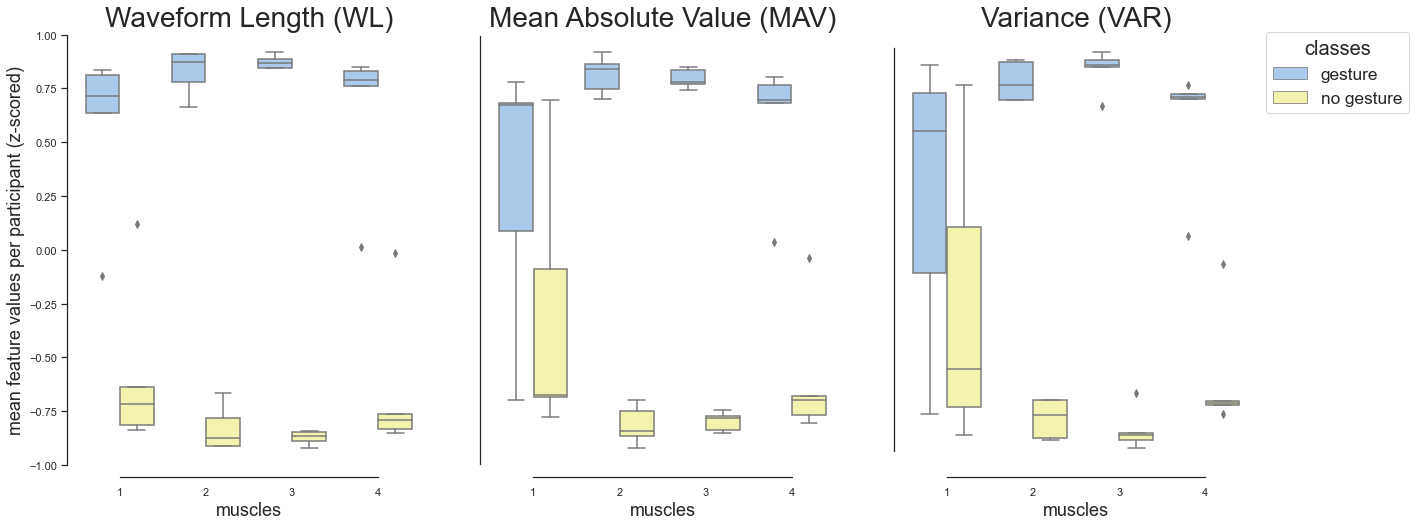

In [18]:
### Plot with subplots

plt.figure(4,(21,8))
fig1 = plt.subplot(1,3,1)

sns.boxplot(x="muscle", y="wl",
            hue="direction", palette=["b", "y"],
            data=ges_muscles)

sns.despine(offset=10, trim=True)

plt.xlabel("muscles",size=18)
plt.ylabel("mean feature values per participant (z-scored)",size=18)
plt.title("Waveform Length (WL)", size=28)
plt.legend([],[], frameon=False) # removing legend
plt.tick_params(bottom=False)

fig2 = plt.subplot(1,3,2)
sns.boxplot(x="muscle", y="mav",
            hue="direction", palette=["b", "y"],
            data=ges_muscles)

sns.despine(offset=10, trim=True)

plt.xlabel("muscles",size=18)
#plt.ylabel("mean absolute value (z-scored)")
ax=plt.gca()
ax.get_yaxis().set_visible(False)
plt.title("Mean Absolute Value (MAV)", size=28)
plt.legend([],[], frameon=False)
plt.tick_params(bottom=False)

fig3 = plt.subplot(1,3,3)
sns.boxplot(x="muscle", y="var",
            hue="direction", palette=["b", "y"],
            data=ges_muscles)

sns.despine(offset=10, trim=True)

plt.xlabel("muscles",size=18)
#plt.ylabel("variance (z-scored)")
ax=plt.gca()
ax.get_yaxis().set_visible(False)
plt.title("Variance (VAR)", size=28)
plt.tick_params(bottom=False)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="classes",borderaxespad=0,
          fontsize = 'x-large', title_fontsize = "20") # legend outside the plot

plt.savefig('C:/Users/Nils/Documents/02_Uni/Master Human Factors/\
00_Masterarbeit/55_github/proxEMG/figure/06_boxplot_gestures_clean',dpi=300, bbox_inches='tight')

#plt.show()


### rotation

In [19]:
# vp1
vp1_rot = dict_rot[1].astype(float).apply(zscore).groupby('direction').mean()
vp1_rot['direction']=vp1_rot.index
vp1_rot['id']=1

# vp2
vp2_rot = dict_rot[2].astype(float).apply(zscore).groupby('direction').mean()
vp2_rot['direction']=vp2_rot.index
vp2_rot['id']=2

# vp3
#vp3_rot = dict_rot[3].astype(float).apply(zscore).groupby('direction').mean()
#vp3_rot['direction']=vp3_rot.index
#vp3_rot['id']=3

# vp4
vp4_rot = dict_rot[4].astype(float).apply(zscore).groupby('direction').mean()
vp4_rot['direction']=vp4_rot.index
vp4_rot['id']=4

# vp5
vp5_rot = dict_rot[5].astype(float).apply(zscore).groupby('direction').mean()
vp5_rot['direction']=vp5_rot.index
vp5_rot['id']=5

# vp6
vp6_rot = dict_rot[6].astype(float).apply(zscore).groupby('direction').mean()
vp6_rot['direction']=vp6_rot.index
vp6_rot['id']=6

In [20]:
rot_means = pd.concat([vp1_rot,vp2_rot,vp4_rot,vp5_rot,vp6_rot], axis=0, ignore_index=True)

In [21]:
rot_m1 = rot_means.iloc[:,[0,1,2,12,13]]
rot_m1 = rot_m1.rename(columns={0:'wl',1:'mav',2:'var'})
rot_m1['muscle']=1

rot_m2 = rot_means.iloc[:,[3,4,5,12,13]]
rot_m2 = rot_m2.rename(columns={3:'wl',4:'mav',5:'var'})
rot_m2['muscle']=2

rot_m3 = rot_means.iloc[:,[6,7,8,12,13]]
rot_m3 = rot_m3.rename(columns={6:'wl',7:'mav',8:'var'})
rot_m3['muscle']=3

rot_m4 = rot_means.iloc[:,[9,10,11,12,13]]
rot_m4 = rot_m4.rename(columns={9:'wl',10:'mav',11:'var'})
rot_m4['muscle']=4

In [22]:
rot_muscles = pd.concat([rot_m1,rot_m2,rot_m3,rot_m4],axis=0,ignore_index=True)

cond=[rot_muscles['direction']<-1, rot_muscles['direction']==0, rot_muscles['direction']>1]
values=['clockwise','anti-clockwise','no rotation']
rot_muscles['direction']=np.select(cond,values)

#### rotation plotting

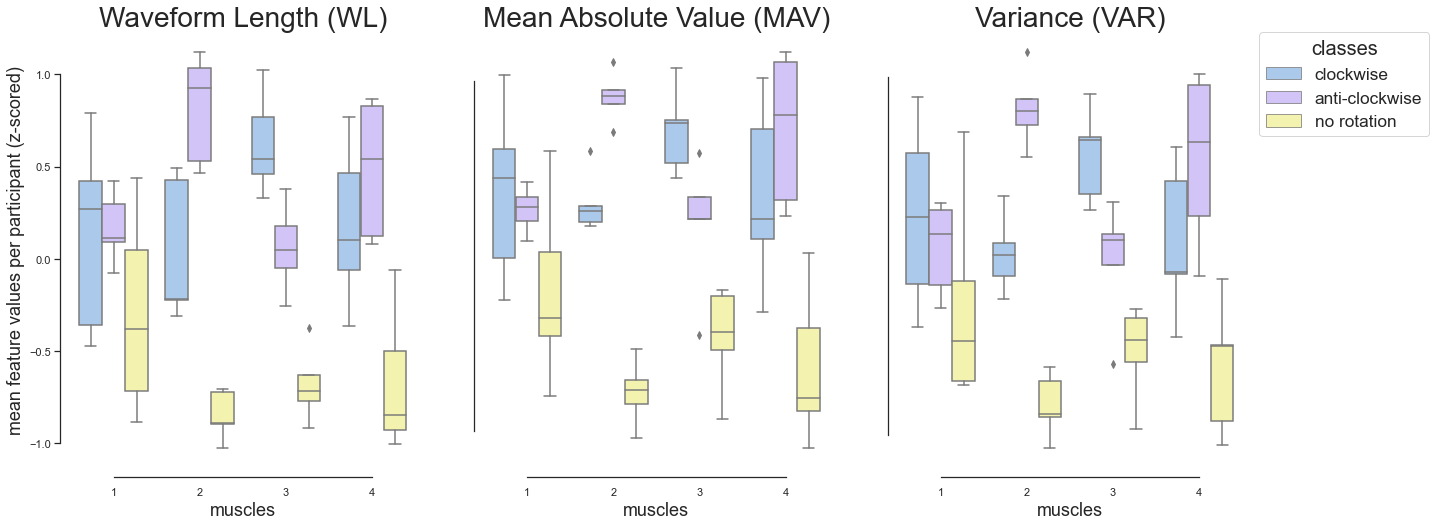

In [23]:
sns.set_theme(style="ticks", palette="pastel")

plt.figure(8,(21,8))
fig1 = plt.subplot(1,3,1)

sns.boxplot(x="muscle", y="wl",
            hue="direction", palette=["b", "m","y"],
            data=rot_muscles)

sns.despine(offset=10, trim=True)

plt.xlabel("muscles",size=18)
plt.ylabel("mean feature values per participant (z-scored)",size=18)
plt.title("Waveform Length (WL)",size=28)
plt.legend([],[], frameon=False) # removing legend
plt.tick_params(bottom=False)

fig2 = plt.subplot(1,3,2)
sns.boxplot(x="muscle", y="mav",
            hue="direction", palette=["b", "m","y"],
            data=rot_muscles)

sns.despine(offset=10, trim=True)

plt.xlabel("muscles",size=18)
#plt.ylabel("mean absolute value (z-scored)")
ax=plt.gca()
ax.get_yaxis().set_visible(False)
plt.title("Mean Absolute Value (MAV)",size=28)
plt.legend([],[], frameon=False)
plt.tick_params(bottom=False)

fig3 = plt.subplot(1,3,3)
sns.boxplot(x="muscle", y="var",
            hue="direction", palette=["b", "m","y"],
            data=rot_muscles)

sns.despine(offset=10, trim=True)

plt.xlabel("muscles",size=18)
#plt.ylabel("variance (z-scored)")
ax=plt.gca()
ax.get_yaxis().set_visible(False)
plt.title("Variance (VAR)",size=28)
plt.tick_params(bottom=False)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="classes",borderaxespad=0,
          fontsize = 'x-large', title_fontsize = "20") # legend outside the plot

plt.savefig('C:/Users/Nils/Documents/02_Uni/Master Human Factors/\
00_Masterarbeit/55_github/proxEMG/figure/06_boxplot_rotation_clean',dpi=300, bbox_inches='tight')

#plt.show()

## demographics + survey

In [24]:
survey_results = pd.DataFrame(columns=['id','age','gender','stars','SUS','fun_importance','fun'])

survey_results['id'] = 1,2,3,4,5,6
survey_results['age'] = 25,25,30,37,26,29 
survey_results['gender'] = 'w','m','m','m','w','m'
survey_results['stars'] = 2,3,4,3,2,4
survey_results['SUS'] = 50,55,75,62.5,50,82.5
survey_results['fun_importance'] = 5,4,4,3,4,3
survey_results['fun'] = 5,3,4,3,4,4

In [25]:
survey_results

,id,age,gender,stars,SUS,fun_importance,fun
0,1,25,w,2,50.0,5,5
1,2,25,m,3,55.0,4,3
2,3,30,m,4,75.0,4,4
3,4,37,m,3,62.5,3,3
4,5,26,w,2,50.0,4,4
5,6,29,m,4,82.5,3,4


In [26]:
results_total = pd.concat([survey_results,ges_results,rot_results], axis=1)
results_total = results_total.loc[:,~results_total.columns.duplicated()] # remove duplicated cols

# remove id=3
results_total=results_total[results_total.id !=3]

In [27]:
results_total.loc['mean']=round(results_total.mean(),2)
results_total['id'] = ['participant','participant','participant','participant','participant','mean']

In [28]:
results_total

,id,age,gender,stars,SUS,fun_importance,fun,ges_cv,ges_cv_sd,ges_75:25,rot_cv,rot_cv_sd,rot_75:25
0,participant,25.0,w,2.0,50.0,5.0,5.0,0.99,0.03,1.0,0.77,0.08,0.82
1,participant,25.0,m,3.0,55.0,4.0,3.0,1.00,0.00,1.0,0.86,0.06,0.92
3,participant,37.0,m,3.0,62.5,3.0,3.0,1.00,0.00,1.0,0.85,0.08,0.82
4,participant,26.0,w,2.0,50.0,4.0,4.0,1.00,0.00,1.0,0.87,0.06,0.89
5,participant,29.0,m,4.0,82.5,3.0,4.0,0.99,0.03,1.0,0.85,0.13,0.87
mean,mean,28.4,NaN,2.8,60.0,3.8,3.8,1.00,0.01,1.0,0.84,0.08,0.86


In [29]:
np.corrcoef(results_total['fun_importance'],results_total['fun'])

array([[1.        , 0.64285714],
       [0.64285714, 1.        ]])

In [30]:
res_mean = round(results_total.mean(),2)
res_std = round(results_total.std(),2)

results_total.append

<bound method DataFrame.append of                id   age gender  stars   SUS  fun_importance  fun  ges_cv  \
0     participant  25.0      w    2.0  50.0             5.0  5.0    0.99   
1     participant  25.0      m    3.0  55.0             4.0  3.0    1.00   
3     participant  37.0      m    3.0  62.5             3.0  3.0    1.00   
4     participant  26.0      w    2.0  50.0             4.0  4.0    1.00   
5     participant  29.0      m    4.0  82.5             3.0  4.0    0.99   
mean         mean  28.4    NaN    2.8  60.0             3.8  3.8    1.00   

      ges_cv_sd  ges_75:25  rot_cv  rot_cv_sd  rot_75:25  
0          0.03        1.0    0.77       0.08       0.82  
1          0.00        1.0    0.86       0.06       0.92  
3          0.00        1.0    0.85       0.08       0.82  
4          0.00        1.0    0.87       0.06       0.89  
5          0.03        1.0    0.85       0.13       0.87  
mean       0.01        1.0    0.84       0.08       0.86  >

In [31]:
print(res_mean)
print(res_std)

age               28.40
stars              2.80
SUS               60.00
fun_importance     3.80
fun                3.80
ges_cv             1.00
ges_cv_sd          0.01
ges_75:25          1.00
rot_cv             0.84
rot_cv_sd          0.08
rot_75:25          0.86
dtype: float64
age                4.54
stars              0.75
SUS               12.14
fun_importance     0.75
fun                0.75
ges_cv             0.01
ges_cv_sd          0.01
ges_75:25          0.00
rot_cv             0.04
rot_cv_sd          0.03
rot_75:25          0.04
dtype: float64


In [32]:
# Correlation
# Schoenbrodt2013: recommendation minimum 150 VP; here: 5
# sample size too small

print('correlation between rot_cv and SUS:', results_total['rot_cv'].corr(results_total['SUS']))

print('correlation between stars and SUS:', results_total['SUS'].corr(results_total['stars']))

print('correlation between stars and rot_cv:', results_total['rot_cv'].corr(results_total['stars']))

print('correlation between fun and SUS:', results_total['fun'].corr(results_total['SUS']))

correlation between rot_cv and SUS: 0.25315801992203874
correlation between stars and SUS: 0.9352525522882807
correlation between stars and rot_cv: 0.37350894041699784
correlation between fun and SUS: -0.1650445680508731


#### scatter plots

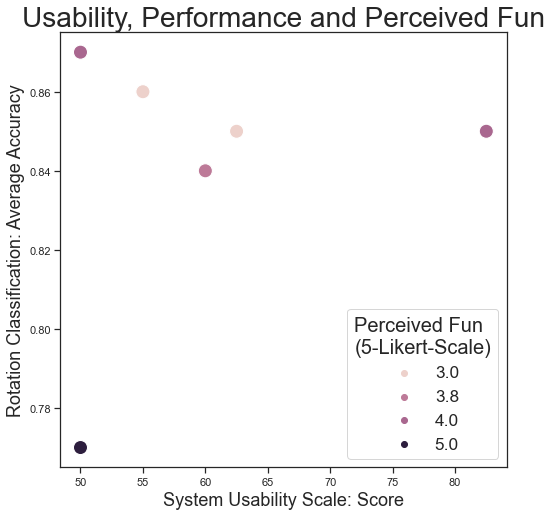

In [33]:
# rot_cv + SUS_score; color=fun

plt.figure(7,(8,8))

# style="stars",

sns.scatterplot(x="SUS", y="rot_cv",
                hue="fun", #palette=['g','b','r'],
                data=results_total,s=200)
plt.xlabel("System Usability Scale: Score",size=18)
plt.ylabel("Rotation Classification: Average Accuracy",size=18)
plt.title("Usability, Performance and Perceived Fun", fontsize="28")

plt.legend(title = "Perceived Fun\n(5-Likert-Scale)", 
           fontsize = 'x-large', title_fontsize = "20")

#plt.savefig('C:/Users/Nils/Documents/02_Uni/Master Human Factors/\
#00_Masterarbeit/55_github/proxEMG/figure/scatter_SUS_ROT_FUN_clean',dpi=300, bbox_inches='tight')
#sns.despine(offset=5, trim=True)

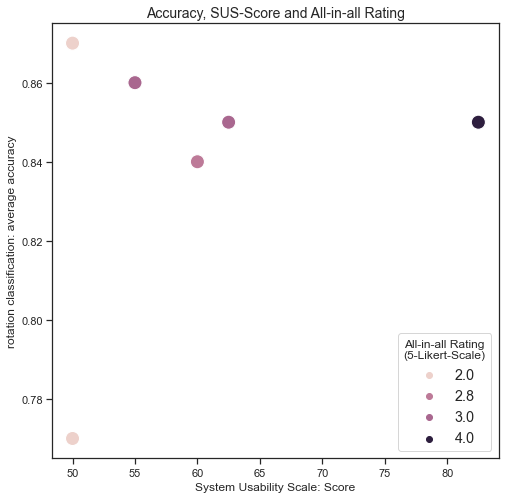

In [34]:
# rot_cv + SUS_score; color=stars

plt.figure(8,(8,8))

sns.scatterplot(x="SUS", y="rot_cv",
                hue="stars",#palette=['g','b','r'],
                data=results_total,s=200)
plt.xlabel("System Usability Scale: Score")
plt.ylabel("rotation classification: average accuracy")
plt.title("Accuracy, SUS-Score and All-in-all Rating", fontsize="14")

plt.legend(title = "All-in-all Rating\n(5-Likert-Scale)", 
           fontsize = 'large', title_fontsize = "12")




#plt.savefig('C:/Users/Nils/Documents/02_Uni/Master Human Factors/\
#00_Masterarbeit/55_github/proxEMG/figure/scatter_SUS_ROT_STARS_clean',dpi=300, bbox_inches='tight')
#sns.despine(offset=5, trim=True)

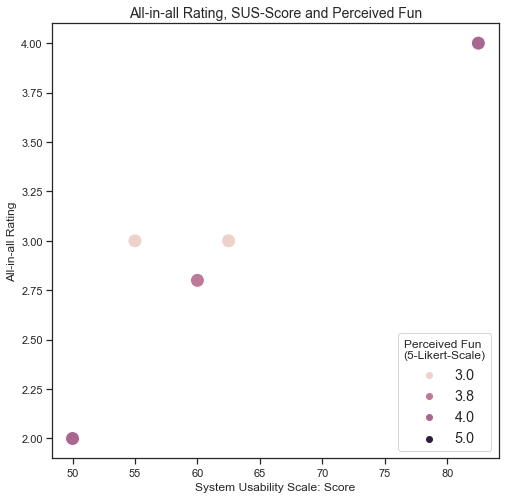

In [35]:
# All_in_all + SUS_score; color=fun

# ATTENTION: two ids with all_in_all = 2, SUS = 50 --> only first one is shown

plt.figure(8,(8,8))

sns.scatterplot(x="SUS", y="stars",
                hue="fun",#palette=['g','b','r'],
                data=results_total,s=200)
plt.xlabel("System Usability Scale: Score")
plt.ylabel("All-in-all Rating")
plt.title("All-in-all Rating, SUS-Score and Perceived Fun", fontsize="14")

plt.legend(title = "Perceived Fun\n(5-Likert-Scale)", 
           fontsize = 'large', title_fontsize = "12",loc="lower right")




#plt.savefig('C:/Users/Nils/Documents/02_Uni/Master Human Factors/\
#00_Masterarbeit/55_github/proxEMG/figure/scatter_SUS_STARS_FUN_clean',dpi=300, bbox_inches='tight')
#sns.despine(offset=5, trim=True)

In [36]:
results_total

,id,age,gender,stars,SUS,fun_importance,fun,ges_cv,ges_cv_sd,ges_75:25,rot_cv,rot_cv_sd,rot_75:25
0,participant,25.0,w,2.0,50.0,5.0,5.0,0.99,0.03,1.0,0.77,0.08,0.82
1,participant,25.0,m,3.0,55.0,4.0,3.0,1.00,0.00,1.0,0.86,0.06,0.92
3,participant,37.0,m,3.0,62.5,3.0,3.0,1.00,0.00,1.0,0.85,0.08,0.82
4,participant,26.0,w,2.0,50.0,4.0,4.0,1.00,0.00,1.0,0.87,0.06,0.89
5,participant,29.0,m,4.0,82.5,3.0,4.0,0.99,0.03,1.0,0.85,0.13,0.87
mean,mean,28.4,NaN,2.8,60.0,3.8,3.8,1.00,0.01,1.0,0.84,0.08,0.86


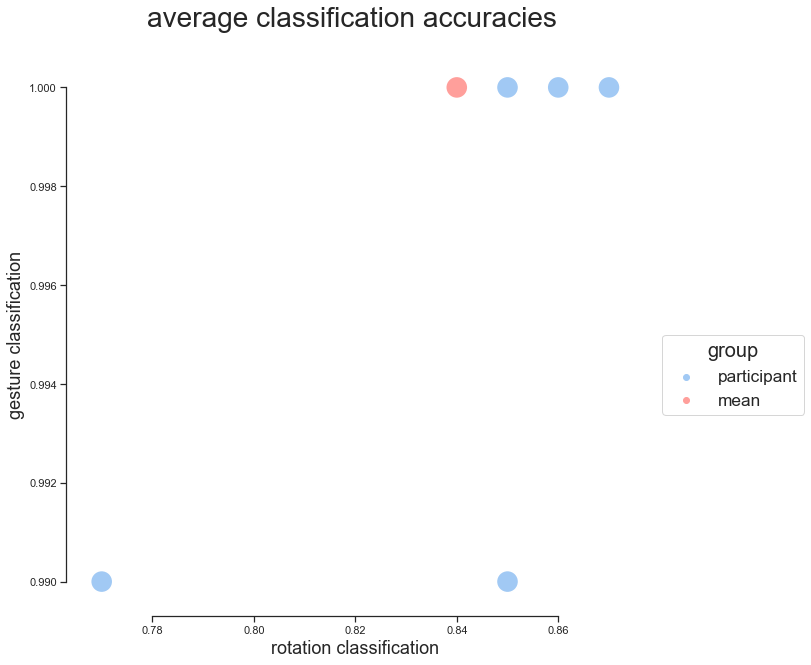

In [37]:
# PLOTTING
plt.figure(9,(10,10))

sns.scatterplot(x="rot_cv", y="ges_cv",
            hue="id", palette=["b","r"],
            s=500,
            data=results_total)

sns.despine(offset=10, trim=True)

plt.xlabel("rotation classification",size=18)
plt.ylabel("gesture classification",size=18)
plt.legend(bbox_to_anchor=(1.05, 0.5), loc='upper left', borderaxespad=0,title="group",
          fontsize='x-large',title_fontsize='20') # legend outside the plot
plt.title("average classification accuracies \n", size=28)

plt.show()

#plt.savefig('C:/Users/Nils/Documents/02_Uni/Master Human Factors/\
#00_Masterarbeit/55_github/proxEMG/figure/06_scatter_classification_accuracies',dpi=300, bbox_inches='tight')